# Practical 3: Variational supervised learning

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions.normal as dist

import time

In this practical you will learn how to implement supervised variational deep learning methods. The starting point is a multi-class logistic regression on the MNIST dataset.

The forward model is just the linear equation
$$
f(x) = W x
$$
where $W$ is a (number of input pixels)x(number of classes) matrix.
The forward model defines the class probabilities through a softmax transformation, which make the output positive and normalized:
$$
p(y_n = j \mid x_n, W) = \frac{e^{f_j(x)}}{\sum_{k=1}^J e^{f_j(x)}}
$$
This results in the usual softmax cross-entropy negative log likelihood loss. Since we want to approximate the Bayesian posterior, we need to specify a prior over the weights. The simplest choice is a uncorrelated normal distribution:
$$
p(W) = \prod_{j,k} p(W_{jk}) = \prod_{j,k} \mathcal{N}(W_{jk} \mid 0, \nu^2)~.
$$
In order to approximate the posterior, we also need to specify a parameterized variational distribution. The simplest choice is to use another parameterized uncorrelated normal distribution:
$$
q(W; M, S) = \prod_{j,k} q(W_{jk}; M_{jk}, S_{jk}) = \prod_{j,k}\mathcal{N}(W_{jk} \mid M_{jk}, S_{jk}^2)~.
$$
where $M$ and $S$ are arrays of learnable variational parameters. Note that we are assuming that the parameters are uncorrelated under the posterior distribution. This approximation is known as mean-field for historical reasons due to its origin in the analysis of the physics of magnets. As we saw in the lecture, we can train these parameters by minimizing the negative ELBO:
$$
\mathcal{L}(\mu^{(q)}, \sigma^{(q)}) = - \mathbb{E}_{W \sim q(W; M, S)}\left[\log{\frac{\left(\prod_{n=1}^N p(y_n \mid x_n, W) \right) \prod_{j,k} \mathcal{N}(W_{jk} \mid 0, \nu^2)}{\prod_{j,k}\mathcal{N}(W_{jk} \mid M_{jk}, S_{jk}^2)}}\right]
$$
Since we cannot evaluate the loss exactly, we use an unbiased gradient estimator using the reparameterization trick:
$$
\mathcal{L}(\mu^{(q)}, \sigma^{(q)}) \approx -\frac{1}{L} \sum_{m=1}^L \left(\log{\frac{\left(\prod_{n=1}^N p(y_n \mid x_n, M_{jk} + S_{jk} \epsilon^{(m)}_{jk}) \right) \prod_{j,k} \mathcal{N}(M_{jk} + S_{jk} \epsilon^{(m)}_{jk} \mid 0, \nu^2)}{\prod_{j,k}\mathcal{N}(M_{jk} + S_{jk} \epsilon^{(m)}_{jk} \mid M_{jk}, S_{jk}^2)}}\right)
$$
where $E_m$ is a matrix of random numbers sampled from uncorrelated standard normal distributions, a random number for each of the weights (remember, we have a posterior distribution for each entry of the forward model weight matrix).

We are now ready to implement this in pytorch! If you are already familiar with Pytorch, most of the following code will be familiar to you. The only difficulty is that we need to perform some re-shaping gymnastic in order to perform batched operations where both the weights and the input have a batch dimension.
This is required since a batch of weights need to be sampled from the variational posterior at every step in order to compute the Monte Carlo gradient estimator.

We start by defining the variational logistic regression class. Be sure toi study the code (including the comments) in details!

Now that the hard work is done, we can load the MNIST data.

In [3]:
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

trainset = datasets.MNIST(root='~/data',download=True, train=True, transform=transform)
testset = datasets.MNIST(root='~/data', download=True, transform=transform)

# Prepare the training set
train_features = torch.cat([data[0].view((1,28*28)) for data in trainset])
train_labels = torch.Tensor([data[1] for data in trainset]).type(torch.long)



In [4]:
class LinearVariational(nn.Module):    
    def __init__(self, in_features, out_features, num_samples, prior_scale):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.num_samples = num_samples
        self.mean_forward = mean_forward
        
        self.prior = dist.Normal(loc = torch.zeros(out_features, in_features),
                                 scale=prior_scale*torch.ones(out_features, in_features))
        
        self.mu_W = nn.Parameter(torch.zeros(out_features, in_features))
        self.s_W = nn.Parameter(torch.zeros(out_features, in_features))

    def get_weight_samples(self, num_samples):
        # reparameterize
        epsilon_dist = dist.Normal(loc = torch.zeros(self.mu_W.size()[0], self.mu_W.size()[1]),
                                    scale = torch.ones(self.mu_W.size()[0], self.mu_W.size()[1]))
        epsilon = epsilon_dist.sample((num_samples,))
        weights = self.mu_W + F.softplus(self.s_W)*epsilon
        return weights
    
    def linear(self, weight_samples, x):
        return torch.matmul(weight_samples.unsqueeze(0), x.unsqueeze(1).unsqueeze(3)).squeeze()
    
    def forward(self, x):
        weight_samples = self.get_weight_samples(self.num_samples)
        out = self.linear(weight_samples, x)
        if (self.mean_forward):
            return out.mean(1)
        else:
            return out

class Variational_Network(nn.Module):
    def __init__(self, in_size, hidden_size, out_size, num_samples):
        super().__init__()
        
        self.latents = LinearVariational(in_features=50,
                              out_features=10, 
                              num_samples=num_samples,
                              prior_scale=5.,
                              mean_forward=False)
        
        self.layers = nn.Sequential(
            # nn.Linear(28*28, 50),
            LinearVariational(in_features=28*28,
                              out_features=50,
                              num_samples=num_samples,
                              prior_scale=5.),
            nn.LeakyReLU(0.1),
            self.latents
        )
    
    def forward(self, x):
        return self.layers(x)
    
    # def evaluate_log_prior(prior, weight_samples):
    #     return torch.mean(prior.log_prob(weight_samples))

    # def evaluate_log_q(mean, scale, weight_samples):
    #     q_dist = dist.Normal(mean, F.softplus(scale))
    #     return torch.mean(q_dist.log_prob(weight_samples))

    
    
    def evaluate_log_likelihood(self, features, labels):
        # preds = self.linear(weight_samples, features) # performs forward, which I want to do explicitly
        preds = self.forward(features)
        data_batch, param_batch, num_classes = preds.shape
        repeated_labels = torch.cat([y.repeat((param_batch,)) for y in labels])
        loss = torch.nn.CrossEntropyLoss(reduction='none')
        log_lk_loss = loss(preds.reshape((data_batch*param_batch, num_classes)), repeated_labels)
        log_lk_loss = -log_lk_loss.reshape((data_batch, param_batch))
        return torch.mean(torch.sum(log_lk_loss, 0))


    def evaluate_ELBO(self, features, labels, correction = 1):
        # weight_samples = self.get_weight_samples(num_samples)
        avg_log_lk = self.evaluate_log_likelihood(features, labels) # y
        q = torch.distributions.normal.Normal(self.latents.mu_W, F.softplus(self.latents.s_W))
        return correction * (avg_log_lk + torch.mean(torch.distributions.kl.kl_divergence(self.latents.prior, q)))
    
    
    def compute_marginalized_predictions(self, features, num_samples):
        pre_preds = self.forward(features)
        preds = nn.Softmax(dim=2)(pre_preds)
        return torch.mean(preds, 1)
        
        
    

We are mostly interested in the low data regime, we will therefore train the variational model with using only $20$ labeled images.

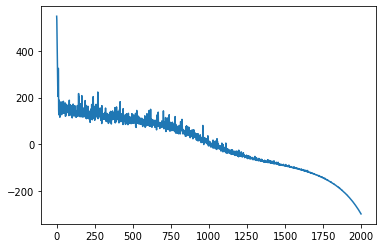

In [5]:
# no minibatching
D = 25
sub_train_features = train_features[:D,:]
sub_train_labels = train_labels[:D]


epochs = 2000
num_samples = 25

variational_network = Variational_Network(in_size=28*28, hidden_size=50, out_size=10, num_samples=num_samples)
optimizer = optim.Adam(variational_network.parameters(), lr=0.001)

loss_list = []
for epoch in range(epochs):
    optimizer.zero_grad()
    
    loss = -variational_network.evaluate_ELBO(sub_train_features, sub_train_labels)
    loss.backward()
    optimizer.step()
    
    loss_list.append(float(loss.detach().numpy()))
    
plt.plot(loss_list)
plt.show()

epoch 0/10 took 218. seconds: 174.6995391845703
epoch 1/10 took 217. seconds: -218.67190551757812
epoch 2/10 took 218. seconds: -263735.65625
epoch 3/10 took 228. seconds: -6465354240.0
epoch 4/10 took 272. seconds: -179616656392192.0
epoch 5/10 took 285. seconds: -3.7416070081182433e+18
epoch 6/10 took 271. seconds: -1.5763664923008516e+22
epoch 7/10 took 260. seconds: -2.3204774562028344e+22
epoch 8/10 took 256. seconds: -2.6138833690463203e+22
epoch 9/10 took 254. seconds: -2.9064896677759666e+22


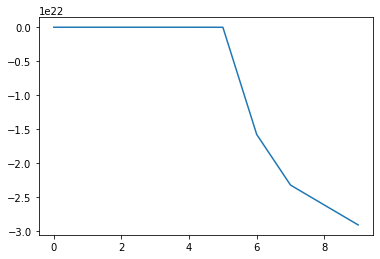

In [9]:
# mini batching
batch_size = 50
epochs = 10
num_samples = 25
variational_network = Variational_Network(in_size=28*28, hidden_size=50, out_size=10, num_samples=num_samples)
optimizer = optim.Adam(variational_network.parameters(), lr=0.001)
data_size = train_features.size()[0]
correction_factor = data_size / batch_size

loss_list = []
for epoch in range(epochs):
    permutation = torch.randperm(data_size)
    start = time.time()
    
    for i in range(0, data_size, batch_size):
        optimizer.zero_grad()
        idxs = permutation[i: i+batch_size]
        sub_train_features = train_features[idxs]
        sub_train_labels = train_labels[idxs]
        
        loss = -variational_network.evaluate_ELBO(sub_train_features, sub_train_labels, correction=1)
        loss.backward()
        optimizer.step()
        
    loss_list.append(float(loss.detach().numpy()))   
    end = time.time() 
    
    print(f"epoch {epoch}/{epochs} took {str(end - start)[:4]} seconds:", float(loss.detach().numpy()))
        
plt.plot(loss_list)
plt.show()

We can finally compute the accuracy of the predictions on the test set:

In [10]:
test_N = 100
val_N = 60000 - test_N
test_set, val_set = torch.utils.data.random_split(testset, [test_N, val_N])


# Prepare test set
test_features = torch.cat([data[0].view((1,28*28)) for data in test_set])
test_labels = torch.Tensor([data[1] for data in test_set]).type(torch.long)

preds = variational_network.compute_marginalized_predictions(test_features, num_samples=100)

print("accuracy:", np.sum(np.array(torch.argmax(preds,1) == test_labels))/test_labels.shape[0])

accuracy: 0.91


## Exercise 1
In the previous code, we are computing the gradient estimator of the whole using the reparameterization trick. This is a bit unefficient as the KL divergence between variational distribution and prior can be computed in closed form. 
Re-implement the loss by separateing the average log-likelihood, which can be estimated using the reparameterization trick, and the the closed KL divergence between prior and variational posterior. You can either implement the formula directly or use the existing pytorch implementation for the KL. 
Compare the speed of convergence. 


## Interlude: Using mini-batches in variational inference

So far we computed the gradient using all available images of the training set. However, when the training set is large, it is necessary to use Monte Carlo estimates of the gradient where the data is sub-sampled. In that case, we need to re-weight the contribution of the likelihood in order to preserve its relative contribution compared to the prior:

$$
\log{p(y_{1:N} \mid x_{1:N})} = \sum_{n=1}^N \log{p(y_n \mid x_n)} \approx \frac{N}{M} \sum_{y_b \in \text{Minibatch}} \log{p(y_b \mid x_b)}
$$

where $M$ is the number of images in the mini-batch. This adjustment is not important in regular deep learning because the log-likelihood is the only component of the loss and scaling total loss does not affect the direction of the gradient update. On the other hand, the ELBO is a balance of three different terms whose relative scale determines the shape of the target posterior. Using mini-bacthes without correction would "let the network think" to have less data than it is actually available. This lead to an over-estimation of the uncertainty.

## Exercise 2
Implement the code for mini-batching correction. Train the variational logistic regression on the whole MNIST training set using mini-batches of $50$ images. 

## Exercise 3
Implement a fully connected variational two-layers network with 50 hidden units and ReLu activations. Compare variational and maximum likelihood results in terms of accuracy and error calibration. Compare with logistic regression in a small data regime ($15$ datapoints) and large data regime ($500$ datapoints). 

Current situation:  
input layer (data dim)  
softmax layer = latent (there is no latent here right?) It's just output

New situation add 2 layers: 
input layer  
50 hidden variational nodes  
50 hidden relu nodes  
latent (there is no latent here right?) It's just output  

## Exercise 4: Bonus exercise for ambitious students
Implement a variational convolutional neural network. You need to find a way to batch the convolutional operation with respect to the sampled weights. (Hint: you can reshape the weight batch dimension into the output channel dimension use the "groups=num_samples" as input to the convolutional layers). If you are less ambitious, you can also decide to use n=1 gradient estimators so to avoid the problem altpogether. Comapre accuracy and calibration with the fully connected network and logistic regression.